# <center> Benchmark Model and Logistic Regression </center>

Let's first try to train a simple logistic regression classifier and see how it compares to the benchmark model.

In [1]:
import numpy as np
from IPython.display import display
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import log_loss, accuracy_score
from capstone_project import preprocessor as pre
from capstone_project import utility

%matplotlib inline

Load train and validation data:

In [2]:
file_directory = "../output/data/"

train_data = pre.load_pickle(file_directory, "train_features.pkl")
val_data = pre.load_pickle(file_directory, "val_features.pkl")
train_labels = pre.load_pickle(file_directory, "train_labels.pkl")
val_labels = pre.load_pickle(file_directory, "val_labels.pkl")

Okay now we can have a look at the dataframe and check if we loaded the correct one:

In [3]:
display(train_data.head(2))

,q1_length,q2_length,diff_length,q1_n_words,q2_n_words,q1_len_word_ratio,q2_len_word_ratio,word_share,word2vec_cosine_distance,word2vec_cityblock_distance,word2vec_jaccard_distance,word2vec_canberra_distance,word2vec_minkowski_distance,word2vec_euclidean_distance,word2vec_braycurtis_distance,word2vec_skew_q1,word2vec_skew_q2,word2vec_kurtosis_q1,word2vec_kurtosis_q2
0,45.0,43.0,2.0,4.0,4.0,11.25,10.75,0.75,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,-0.115227,-0.115227,-0.246681,-0.246681
1,35.0,28.0,7.0,4.0,2.0,8.75,14.00,0.75,0.299657,10.757644,1.0,156.069648,0.345219,0.774154,0.427605,-0.005088,0.076298,-0.112236,0.017166


We are going to use a pipeline to scale the features and train a logistic regression with its default values:

In [4]:
mms = MinMaxScaler()
clf = LogisticRegression()

pipe = Pipeline([("minmax_scaler", mms), ("logisitc_regression", clf)])


pipe.fit(train_data.values, train_labels)

Pipeline(steps=[('minmax_scaler', MinMaxScaler(copy=True, feature_range=(0, 1))), ('logisitc_regression', LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False))])

Save the model in case we need it later:

In [5]:
model_directory = "../output/models"
prefix = "for_validation_"

pre.save_pickle(pipe, model_directory, prefix+"logistic_pipe.pkl") 

Create prediction on the validation data:

In [6]:
predictions_log = pipe.predict_proba(val_data)[:,1]

Calculate validation scores:

In [7]:
loss = log_loss(val_labels, predictions_log)
acc = accuracy_score(val_labels, np.rint(predictions_log))

print "Validation scores for the Logsitic regression\n LogLoss: {:.4f}\n Accuracy: {:.2f} ".format(loss, acc)

Validation scores for the Logsitic regression
 LogLoss: 0.5242
 Accuracy: 0.68 


and create receiver operation characteristic plot:

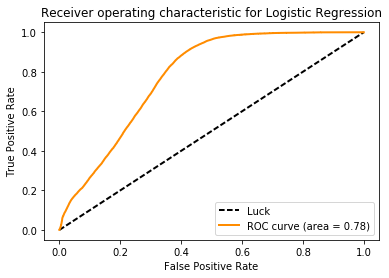

In [8]:
plt = utility.create_roc_plot(val_labels, predictions_log, "Logistic Regression")
plt.savefig("../output/figures/logistic_roc_plot.png")
plt.show()

Now let's calculate the benchmark model scores in order to be able to compare them to our logistic regression scores:

In [9]:
predictions = val_data["word_share"]

loss = log_loss(val_labels, predictions)
acc = accuracy_score(val_labels, np.rint(predictions))

print "Validation scores for the benchmark model\n LogLoss: {:.4f}\n Accuracy: {:.2f} ".format(loss, acc)

Validation scores for the benchmark model
 LogLoss: 0.7603
 Accuracy: 0.69 


and let's create a ROC plot for the benchmark model too:

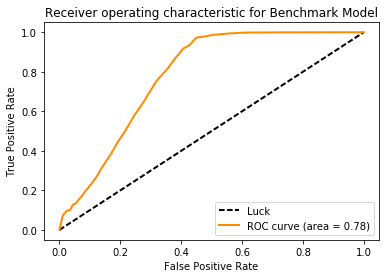

In [10]:
plt = utility.create_roc_plot(val_labels, predictions, "Benchmark Model")
plt.savefig("../output/figures/word_share_roc_plot.png")
plt.show()